In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/drive/My Drive/Thesis/official_data')

['fiction_images', 'updated_fiction_official.csv']

In [ ]:
import pandas as pd

data_path = "/content/drive/My Drive/Thesis/official_data/updated_fiction_official.csv"
data = pd.read_csv(data_path)

print(data.head())

                              title  \
0                        Mockingjay   
1            The Fault in Our Stars   
2               Bring Up the Bodies   
3  The Ocean at the End of the Lane   
4                       The Passage   

                                              author    year  \
0                                    Suzanne Collins  2010.0   
1                                         John Green  2010.0   
2                                      Hilary Mantel  2012.0   
3  Neil Gaiman, Mónica Faerna, Patrick Marcel, Ll...  2013.0   
4                                      Justin Cronin  2010.0   

                                           cover_url  \
0  https://covers.openlibrary.org/b/id/12646459-L...   
1  https://covers.openlibrary.org/b/id/7418786-L.jpg   
2  https://covers.openlibrary.org/b/id/10236749-L...   
3  https://covers.openlibrary.org/b/id/7258156-L.jpg   
4  https://covers.openlibrary.org/b/id/8261369-L.jpg   

                                         de

In [ ]:
!pip install huggingface_hub[hf_xet]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 10.4 MB/s eta 0:00:00


LOGISTIC REGRESSION



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, average_precision_score
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Load data
texts = data["clean_text"]
labels = data["label"]

# Load BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Function to get BERT CLS token embeddings
def get_embeddings(text_list):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(text_list):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Generate embeddings
X = get_embeddings(texts.tolist())
y = labels.values

# 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 4666/4666 [20:21<00:00,  3.82it/s]


LogisticRegression(max_iter=1000, random_state=42)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

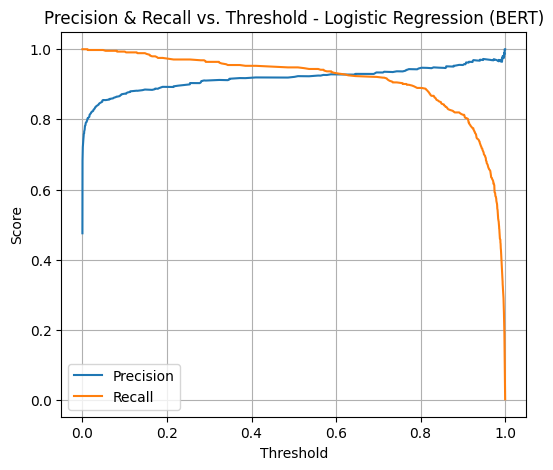

In [ ]:
from google.colab import files
# Predict probabilities on test set
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
plt.figure(figsize=(6, 5))
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds_pr, precision[:-1], label='Precision')
plt.plot(thresholds_pr, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold - Logistic Regression (BERT)')
plt.legend()
plt.grid()
#plt.show()
# Save the figure
# Save the plot as a .png file
plt.savefig("/content/logreg_bert_precision_recall_threshold_curve.png", dpi=300)
# Download the saved plot
files.download("/content/logreg_bert_precision_recall_threshold_curve.png")

In [ ]:
# Apply threshold to get binary predictions
y_pred = (y_probs >= 0.8).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Explanation: I chose the threshold 0.8.
# If i increase to 0.9, precision increases from 0.95 to 0.96 but recall drops from 0.89 to 0.81.
# So the drop in recall is not worth it. it is best to keep it at 0.8

Accuracy: 0.923982869379015
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       490
           1       0.95      0.89      0.92       444

    accuracy                           0.92       934
   macro avg       0.93      0.92      0.92       934
weighted avg       0.93      0.92      0.92       934



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

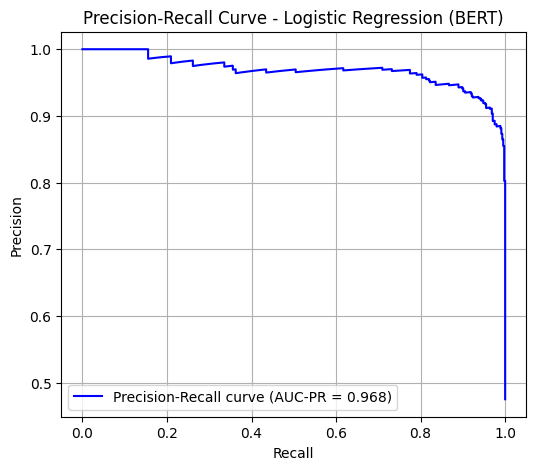

In [ ]:
from google.colab import files
# Precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
auc_pr = average_precision_score(y_test, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color='b', label=f'Precision-Recall curve (AUC-PR = {auc_pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (BERT)')
plt.legend(loc='best')
plt.grid()
# Save the plot as a .png file
plt.savefig("/content/logreg_bert_precision_recall_curve.png", dpi=300)
# Download the saved plot
files.download("/content/logreg_bert_precision_recall_curve.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

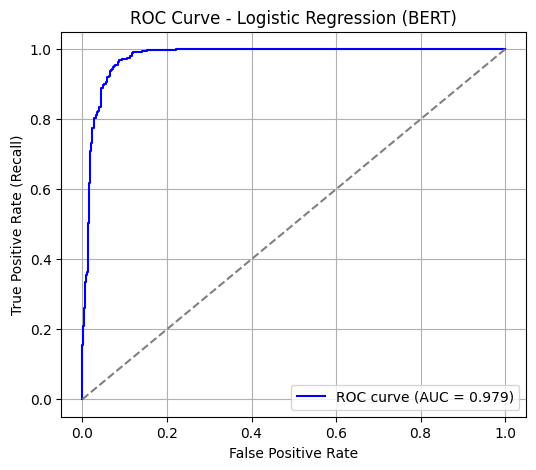

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for class 1
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Logistic Regression (BERT)')
plt.legend(loc='best')
plt.grid()
# Save the plot as a .png file
plt.savefig("/content/logreg_bert_roc.png", dpi=300)
# Download the saved plot
files.download("/content/logreg_bert_roc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

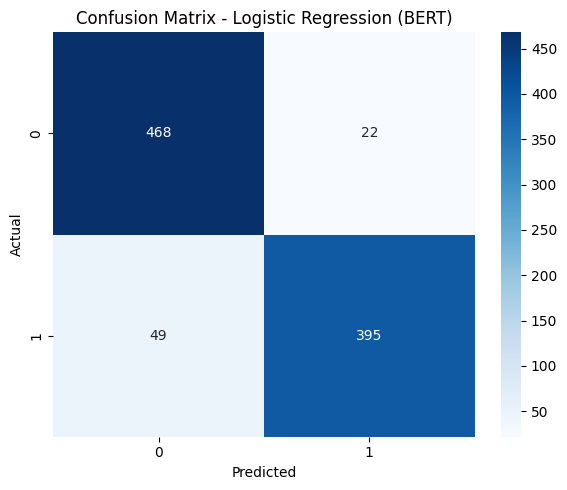

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (BERT)')
plt.tight_layout()

# Save the plot as a .png file with higher DPI
plt.savefig("/content/logreg_bert_confusion_matrix.png", dpi=300)

# Download the saved plot
files.download("/content/logreg_bert_confusion_matrix.png")

RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_recall_curve, average_precision_score
)
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data
texts = data["clean_text"]
labels = data["label"]

# Load BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Function to get CLS token embedding from BERT
def get_embeddings(text_list):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(text_list):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Generate embeddings
X = get_embeddings(texts.tolist())
y = labels.values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict probabilities
y_probs = rf_model.predict_proba(X_test)[:, 1]

100%|██████████| 4666/4666 [19:35<00:00,  3.97it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

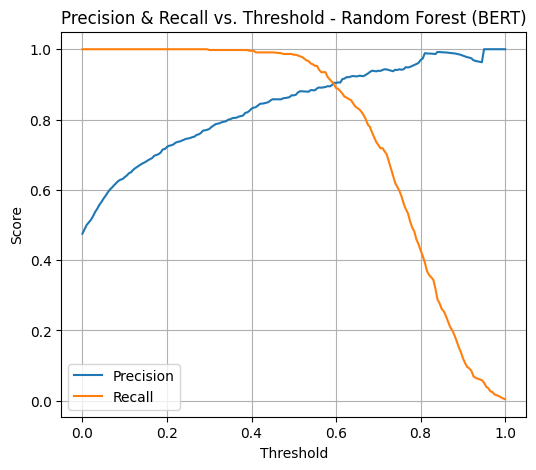

In [ ]:
from google.colab import files
# Predict probabilities on test set
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
plt.figure(figsize=(6, 5))
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds_pr, precision[:-1], label='Precision')
plt.plot(thresholds_pr, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold - Random Forest (BERT)')
plt.legend()
plt.grid()
#plt.show()
# Save the figure
# Save the plot as a .png file
plt.savefig("/content/rf_bert_precision_recall_threshold_curve.png", dpi=300)
# Download the saved plot
files.download("/content/rf_bert_precision_recall_threshold_curve.png")

In [ ]:
y_pred = (y_probs >= 0.65).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Explanation: when increasing from 0.6 to 0.65, precision increases from 0.90 to 0.92, but recall drops from 0.89 to 0.83.
# F1 score drops from 0.90 to 0.88. Also, accuracy drops from 0.90 to 0.89. Based on this, the 0.65 threshold is acceptable.
# so by increasing from 0.6 to 0.65, there is no huge drop in performance.

Accuracy: 0.8875802997858673
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       490
           1       0.92      0.83      0.88       444

    accuracy                           0.89       934
   macro avg       0.89      0.89      0.89       934
weighted avg       0.89      0.89      0.89       934



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

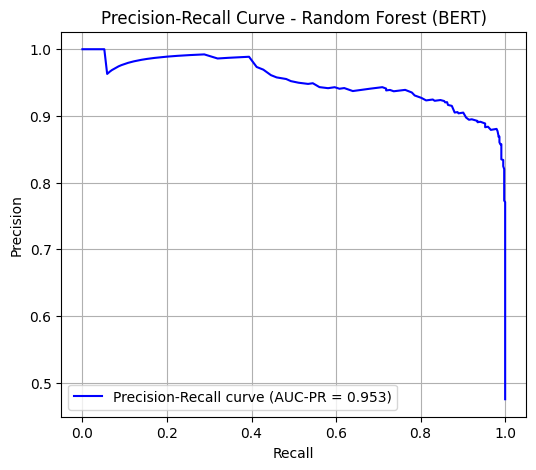

In [ ]:
from google.colab import files
# Precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
auc_pr = average_precision_score(y_test, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color='b', label=f'Precision-Recall curve (AUC-PR = {auc_pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (BERT)')
plt.legend(loc='best')
plt.grid()
# Save the plot as a .png file
plt.savefig("/content/rf_bert_precision_recall_curve.png", dpi=300)
# Download the saved plot
files.download("/content/rf_bert_precision_recall_curve.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

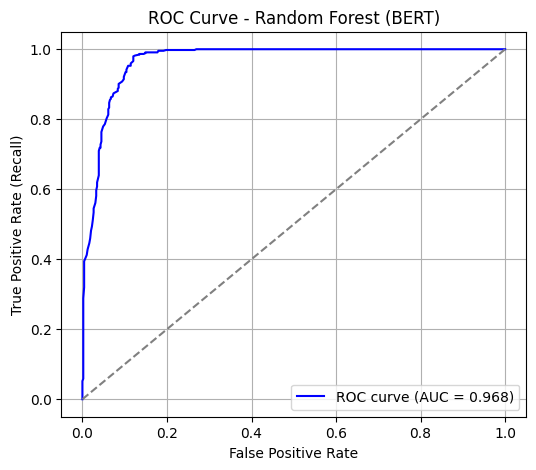

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for class 1
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Random Forest (BERT)')
plt.legend(loc='best')
plt.grid()
# Save the plot as a .png file
plt.savefig("/content/rf_bert_roc.png", dpi=300)
# Download the saved plot
files.download("/content/rf_bert_roc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

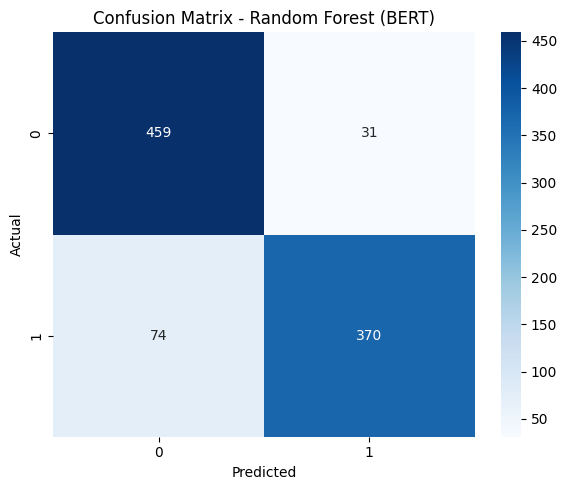

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (BERT)')
plt.tight_layout()

# Save the plot
plt.savefig("/content/rf_bert_confusion_matrix.png", dpi=300)

# Download the saved plot
files.download("/content/rf_bert_confusion_matrix.png")

XGBoost

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_recall_curve, average_precision_score
)
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import files
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# Load data
texts = data["clean_text"]
labels = data["label"]

# Load BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Function to get CLS token embedding from BERT
def get_embeddings(text_list):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(text_list):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Generate embeddings
X = get_embeddings(texts.tolist())
y = labels.values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train XGBoost with default parameters
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict probabilities for class 1
y_probs = xgb_model.predict_proba(X_test)[:, 1]

100%|██████████| 4666/4666 [19:13<00:00,  4.05it/s]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

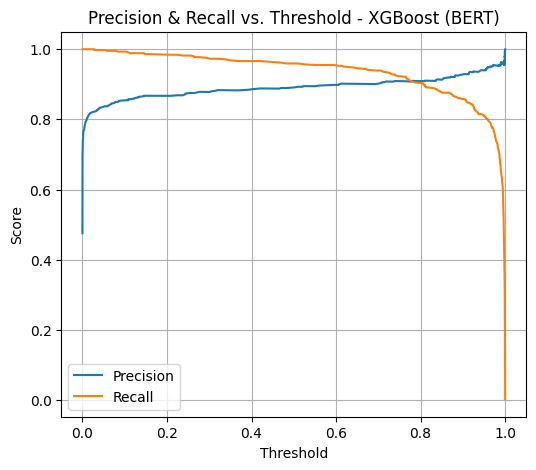

In [ ]:
from google.colab import files
# Predict probabilities on test set
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
plt.figure(figsize=(6, 5))
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds_pr, precision[:-1], label='Precision')
plt.plot(thresholds_pr, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold - XGBoost (BERT)')
plt.legend()
plt.grid()
#plt.show()
# Save the figure
# Save the plot as a .png file
plt.savefig("/content/xgboost_bert_precision_recall_threshold_curve.png", dpi=300)
# Download the saved plot
files.download("/content/xgboost_bert_precision_recall_threshold_curve.png")

In [ ]:
y_pred = (y_probs >= 0.9).astype(int)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Explanation: 0.9 is the threshold chosen. Increasing from 0.8 to 0.9, precision increases from 0.91 to 0.93, but recall drops from 0.90 to 0.86.
# However, F1 score only drops from 0.91 to 0.89. The accuracy drops from 0.91 to 0.90. So threshold 0.90 is reasonable.

Accuracy: 0.9015
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       490
           1       0.93      0.86      0.89       444

    accuracy                           0.90       934
   macro avg       0.90      0.90      0.90       934
weighted avg       0.90      0.90      0.90       934



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

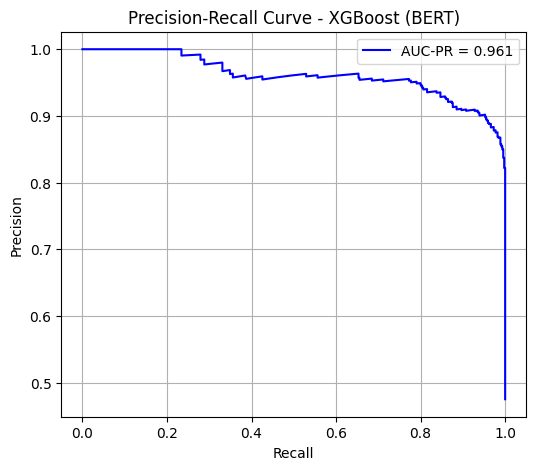

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_prec = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='b', label=f'AUC-PR = {avg_prec:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost (BERT)")
plt.legend()
plt.grid()
plt.savefig("/content/xgb_bert_pr_curve.png", dpi=300)
files.download("/content/xgb_bert_pr_curve.png")
plt.show()
plt.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

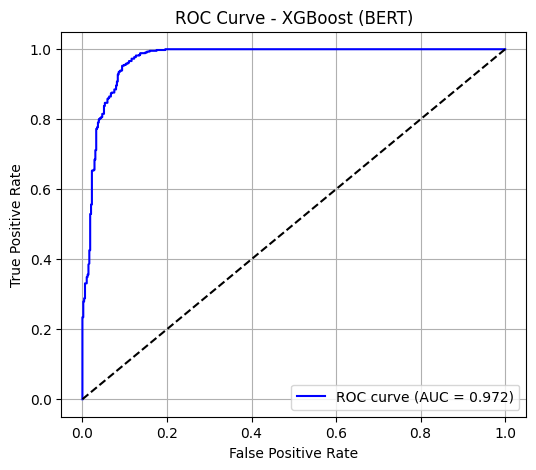

In [ ]:
# ROC Curve
from sklearn.metrics import auc
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (BERT)')
plt.legend()
plt.grid()
plt.savefig("/content/xgb_bert_roc.png", dpi=300)
files.download("/content/xgb_bert_roc.png")
plt.show()
plt.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

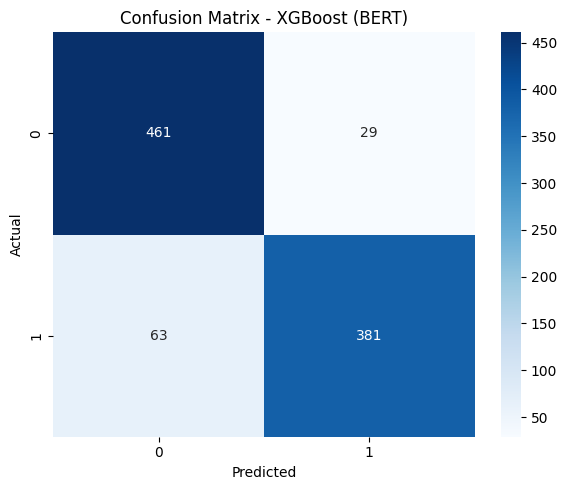

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost (BERT)')
plt.tight_layout()

# Save the plot as a .png file with higher DPI
plt.savefig("/content/xgboost_bert_confusion_matrix.png", dpi=300)

# Download the saved plot
files.download("/content/xgboost_bert_confusion_matrix.png")